# **Alvito Kiflan Hawari (1103220235)**

## **Main Objective**
Mendesain dan mengimplementasikan *end-to-end regression pipeline* untuk memprediksi nilai target kontinu (kolom pertama dataset) dari fitur numerik menggunakan machine learning (model utama: **XGBoost Regressor**).

## **Ringkasan Workflow**
1. Unduh & load data (*gdown* + `pandas.read_csv()`).
2. Exploratory check: cek dimensi data, tipe data, *missing values*, dan duplikasi.
3. Data cleaning: `drop_duplicates()`, buang baris dengan target kosong, serta konversi fitur ke numerik.
4. *Train/test split* (20% test) dan setup *cross-validation* (KFold).
5. *Outlier handling* pada fitur dengan *quantile clipping* (1%–99%) berbasis statistik data train, lalu diterapkan ke test.
6. Preprocessing & *feature selection*: imputasi median (`SimpleImputer`) + `SelectKBest(f_regression)`.
7. Training model regresi dalam *scikit-learn Pipeline* menggunakan `XGBRegressor`.
8. *Hyperparameter tuning* minimal 1 model dengan `RandomizedSearchCV`.
9. Evaluasi performa pada test set (MSE, RMSE, MAE, R²) + visualisasi (*Actual vs Predicted* dan *Residual Plot*).


Sel ini menginstal pustaka `gdown`, yang digunakan untuk mengunduh file dari Google Drive.

In [ ]:
pip install gdown

Sel ini menggunakan `gdown` untuk mengunduh dataset dari tautan Google Drive yang diberikan dan menyimpannya sebagai `midterm-regresi-dataset.csv`.

In [ ]:
import gdown

gdown.download("https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9")

Downloading...
From (original): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9
From (redirected): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9&confirm=t&uuid=3de5248f-1d03-407c-8dc6-4661aaf5f17a
To: /content/midterm-regresi-dataset.csv
100%|██████████| 443M/443M [00:12<00:00, 34.2MB/s]


'midterm-regresi-dataset.csv'

Sel ini mengimpor pustaka `pandas`, kemudian memuat file CSV yang telah diunduh ke dalam DataFrame. Perhatikan bahwa dataset ini tidak memiliki baris header, dan kolom pertama dianggap sebagai target (`tahun`). Selanjutnya, sel ini menampilkan lima baris pertama dari DataFrame.

In [ ]:
import pandas as pd


# Dataset ini tidak punya header.
# Nilai seperti 2001 di kolom pertama adalah TARGET (tahun), bukan nama feature /  kolom.
file_path = '/content/midterm-regresi-dataset.csv'
df = pd.read_csv(file_path)

df.head()

,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
4,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263


Sel ini mencetak bentuk (jumlah baris dan kolom) dari DataFrame `df`, memberikan gambaran awal tentang ukuran dataset.

In [ ]:
print("df.shape:", df.shape) #ada 515344 row/baris dan 90 feature

df.shape: (515344, 91)


Sel ini menggunakan modul `os` untuk mendapatkan ukuran file CSV dalam byte dan mengkonversinya menjadi megabyte. Ini memberikan informasi tentang seberapa besar dataset yang sedang digunakan.

In [ ]:
import os
file_size_bytes = os.path.getsize(file_path)
file_size_mb = file_size_bytes / (1024 ** 2)

print(f"Ukuran file: {file_size_bytes:,} bytes")
print(f"Ukuran file: {file_size_mb:.2f} MB")  #ukuran 422.88 MB, deadline 2 minggu. ngerjain mepet pasti ga kelar :))))

Ukuran file: 443,423,087 bytes
Ukuran file: 422.88 MB


## **IMPORT**

Sel ini mengimpor semua pustaka Python yang diperlukan untuk analisis data, pemodelan machine learning, dan evaluasi, termasuk `numpy`, `pandas`, `matplotlib`, `sklearn`, dan `xgboost`. `RANDOM_STATE` juga ditetapkan untuk memastikan reproduktifitas hasil.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

from xgboost import XGBRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## **HANDLE MISSING VALUES**

Sel ini melakukan beberapa langkah pra-pemrosesan data:
1.  **Menghilangkan duplikat:** Baris duplikat dihapus dari DataFrame untuk menghindari bias.
2.  **Memisahkan target dan fitur:** Kolom pertama (target) disimpan ke `y` (tipe integer) dan sisa kolom (fitur) disimpan ke `X` (tipe float).
3.  **Mencetak bentuk dan rentang target:** Menampilkan dimensi `X` dan `y` serta nilai minimum dan maksimum dari target `y`.

In [ ]:
# drop duplicate rows (opsional tapi bagus)
df = df.drop_duplicates().reset_index(drop=True)

# target = kolom 0, fitur = kolom 1..end
y = df.iloc[:, 0].astype(int)
X = df.iloc[:, 1:].astype(float)

print("X:", X.shape, "y:", y.shape)
print("y min/max:", y.min(), y.max())

X: (515130, 90) y: (515130,)
y min/max: 1922 2011


Sel ini menangani nilai `NaN` (Not a Number) atau missing values pada variabel target `y`. Baris yang memiliki missing values pada `y` akan dihapus dari `X` dan `y` untuk memastikan integritas data. Kemudian, dicetak bentuk `X` dan `y` setelah penghapusan serta jumlah total missing values di `X`.

In [ ]:
mask = y.notna()
X = X.loc[mask].copy()
y = y.loc[mask].copy()

print("After drop missing y -> X:", X.shape, "y:", y.shape)
print("Missing X total:", X.isna().sum().sum())


After drop missing y -> X: (515130, 90) y: (515130,)
Missing X total: 0


## **TRAIN/TEST SPLIT**

Sel ini membagi dataset menjadi set pelatihan (training set) dan set pengujian (test set) menggunakan `train_test_split` dari scikit-learn. Sebanyak 20% data dialokasikan untuk pengujian, dan `random_state` diatur untuk memastikan pembagian yang konsisten.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (412104, 90) (412104,)
Test : (103026, 90) (103026,)


## **OUTLIER HANDLING**

Sel ini mendefinisikan dan menerapkan fungsi `clip_outliers_train_test` untuk menangani *outlier* pada fitur `X_train` dan `X_test`. Outlier dipotong (clipped) pada batas kuantil ke-1 dan ke-99 yang dihitung hanya dari data pelatihan. Ini membantu mencegah nilai ekstrem memengaruhi model secara negatif. `X_train_used` dan `y_train_used` disiapkan untuk langkah tuning dan training.

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Clip outliers on features (train stats only)
def clip_outliers_train_test(X_train, X_test, lower_q=0.01, upper_q=0.99):
    lo = X_train.quantile(lower_q)
    hi = X_train.quantile(upper_q)
    return X_train.clip(lo, hi, axis=1), X_test.clip(lo, hi, axis=1)

X_train, X_test = clip_outliers_train_test(X_train, X_test, 0.01, 0.99)

# Untuk tuning/training
X_train_used, y_train_used = X_train, y_train


## **PIPELINE + FEATURE SELECTION + MODEL (XGBoost)**

Sel ini membangun pipeline machine learning menggunakan `sklearn.pipeline.Pipeline`.
*   **`SimpleImputer`**: Mengisi nilai yang hilang di `X` dengan median.
*   **`SelectKBest`**: Memilih 40 fitur terbaik berdasarkan skor F-regresi.
*   **`XGBRegressor`**: Model regresi menggunakan XGBoost dengan parameter tertentu seperti `objective`, `random_state`, dan `eval_metric`. Metode `tree_method` diatur ke 'hist' dan `predictor` ke 'cpu_predictor' karena deteksi GPU tidak berhasil.

In [ ]:
import torch

tree_method = "hist"
predictor = "cpu_predictor"
print("XGBoost GPU method 'gpu_hist' is not recognized. Falling back to CPU-based 'hist' method.")

pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),     # handle missing X
    ("select", SelectKBest(score_func=f_regression, k=40)),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method=tree_method,
        predictor=predictor,
        eval_metric="rmse"
    ))
])

XGBoost GPU method 'gpu_hist' is not recognized. Falling back to CPU-based 'hist' method.


## **BASIC HYPERPARAMETER TUNING**

Sel ini melakukan *hyperparameter tuning* menggunakan `RandomizedSearchCV` untuk menemukan kombinasi parameter terbaik untuk pipeline.
*   **`KFold`**: Digunakan untuk validasi silang (cross-validation) dengan 5 lipatan.
*   **`param_dist`**: Mendefinisikan distribusi parameter yang akan dicari.
*   **`search.fit`**: Melatih model dengan mencari parameter terbaik pada `X_train_used` dan `y_train_used`.
*   **Output**: Mencetak parameter terbaik dan RMSE validasi silang terbaik. Model terbaik disimpan ke `best_model`.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_dist = {
    "select__k": [20, 30, 40, 50, 60, "all"],
    "model__n_estimators": [600, 1200, 2000],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__max_depth": [3, 4, 5, 6, 8],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__min_child_weight": [1, 3, 5, 10],
    "model__reg_alpha": [0.0, 1e-3, 1e-2, 0.1, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0, 5.0],
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,                       # basic tuning
    cv=cv,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_used, y_train_used)

print("Best params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)

best_model = search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:06:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'select__k': 'all', 'model__subsample': 0.6, 'model__reg_lambda': 5.0, 'model__reg_alpha': 1.0, 'model__n_estimators': 2000, 'model__min_child_weight': 10, 'model__max_depth': 6, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Best CV RMSE: 8.698505020141601


## **FINAL EVALUATION (MSE, RMSE, MAE, R²) + PLOT**

Sel ini mengevaluasi kinerja model terbaik (`best_model`) pada set pengujian (`X_test`, `y_test`).
*   **Metrik Evaluasi**: Menghitung Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), dan R-squared (R²).
*   **Plot Aktual vs Prediksi**: Menampilkan scatter plot yang membandingkan nilai aktual dengan nilai prediksi, berguna untuk visualisasi seberapa baik model memprediksi.
*   **Plot Residual**: Menampilkan scatter plot residual (selisih antara nilai aktual dan prediksi) terhadap nilai prediksi. Plot ini membantu mengidentifikasi pola atau masalah dalam prediksi model.

{'MSE': 74.49688720703125, 'RMSE': np.float64(8.631157929677295), 'MAE': 6.061916828155518, 'R2': 0.3724302649497986}


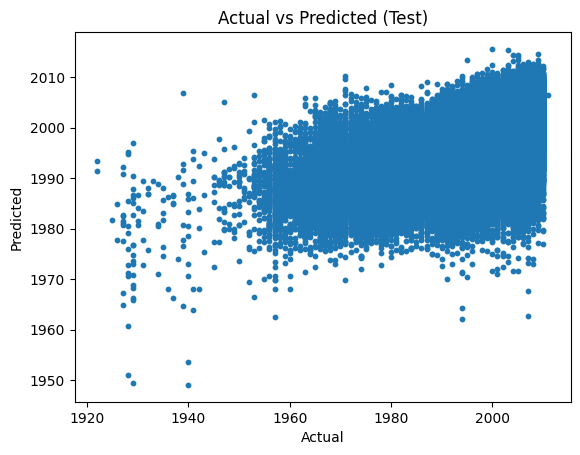

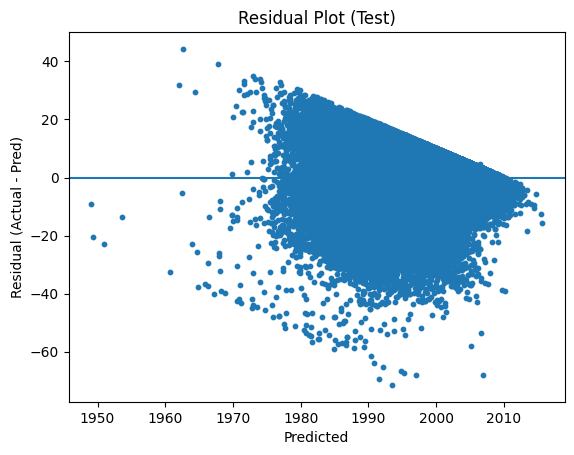

In [ ]:
pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print({"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2})

# Actual vs Predicted
plt.figure()
plt.scatter(y_test, pred, s=10)
plt.title("Actual vs Predicted (Test)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Residual plot
res = y_test - pred
plt.figure()
plt.scatter(pred, res, s=10)
plt.axhline(0)
plt.title("Residual Plot (Test)")
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Pred)")
plt.show()